In [ ]:
%%capture
!pip install torchmetrics[audio]
!pip install pesq

In [ ]:
from torchmetrics.audio import PerceptualEvaluationSpeechQuality, ShortTimeObjectiveIntelligibility, ScaleInvariantSignalNoiseRatio

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import math
from torch.quantization import quantize_dynamic, QuantType
from IPython.display import Audio, display
import torchaudio
from torchaudio.functional import resample
from torch.profiler import profile, record_function, ProfilerActivity
import os
from tqdm import tqdm
import pandas as pd

In [ ]:
!rm -rf mobile-computing-project

In [ ]:
!git clone https://github.com/nickbclifford/mobile-computing-project.git

Cloning into 'mobile-computing-project'...
remote: Enumerating objects: 380, done.
remote: Counting objects: 100% (380/380), done.
remote: Compressing objects: 100% (241/241), done.
remote: Total 380 (delta 144), reused 313 (delta 79), pack-reused 0
Receiving objects: 100% (380/380), 16.71 MiB | 13.65 MiB/s, done.
Resolving deltas: 100% (144/144), done.


In [ ]:
import sys
sys.path.append('mobile-computing-project')

In [ ]:
from denoising import demucs, quantized_demucs

In [ ]:
# all imports
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  return audio, BytesIO(b)

In [ ]:
def tensor_to_audio(x, s):
  if len(x.shape) != 2:
    x = x.squeeze(1)

  torchaudio.save('./test1.wav', x, s)
  display(Audio('./test1.wav'))

In [ ]:
def model_perf(model, sample):
  with profile(activities=[ProfilerActivity.CPU], record_shapes=True, profile_memory=True) as prof:
    with record_function("model_inference"):
      with torch.no_grad():
        for _ in range(10):
          res = model(sample).cpu().numpy()
    print(res)

  print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

In [ ]:
def get_size_of_model(model):
  torch.save(model.state_dict(), "temp.p")
  size=os.path.getsize("temp.p")
  os.remove('temp.p')
  return size

In [ ]:
def print_size_of_model(model, label=""):
    size = get_size_of_model(model)
    print("model: ",label,' \t','Size (KB):', size/1e3)
    return size

In [ ]:
!curl -o test_noisy.zip https://datashare.ed.ac.uk/bitstream/handle/10283/2791/noisy_testset_wav.zip?sequence=5&isAllowed=y

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  7855k      0  0:00:21  0:00:21 --:--:-- 12.1M


In [ ]:
!curl -o test_clean.zip https://datashare.ed.ac.uk/bitstream/handle/10283/2791/clean_testset_wav.zip?sequence=1&isAllowed=y

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  147M  100  147M    0     0  9271k      0  0:00:16  0:00:16 --:--:-- 16.5M


In [ ]:
%%capture
!unzip test_noisy.zip

In [ ]:
%%capture
!unzip test_clean.zip

In [ ]:
from torchaudio.transforms import Resample

In [ ]:
# making Dataset
class ValentiniDataset(torch.utils.data.Dataset):
    def __init__(self, noisy_dir, clean_dir, max_size = None, sample_hz=16000, transform=None):
        self.noisy_dir = noisy_dir
        self.clean_dir = clean_dir
        self.transform = transform
        self.sample_hz = sample_hz

        self.files = os.listdir(noisy_dir)
        self.files = list(zip(
            [os.path.join(noisy_dir, f) for f in self.files],
            [os.path.join(clean_dir, f) for f in self.files]
        ))

        if max_size is not None:
            self.files = self.files[:max_size]
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        noisy, clean = self.files[idx]
        noisy, fs1 = torchaudio.load(noisy)
        clean, fs2 = torchaudio.load(clean)

        # Resample
        noisy = resample(noisy, fs1, self.sample_hz)
        clean = resample(clean, fs2, self.sample_hz)

        if self.transform:
            noisy = self.transform(noisy)
            clean = self.transform(clean)


        return noisy, clean

In [ ]:
# For use in static quantization observer
sample_dataset = ValentiniDataset('noisy_testset_wav', 'clean_testset_wav', max_size=10)
sample_dataloader = torch.utils.data.DataLoader(sample_dataset, batch_size=1, shuffle=False)

In [ ]:
dynamic_only = quantized_demucs.QuantizedDemucs.from_facebook_pretrained('dns48', dict(encoder=False, lstm=False), dynamic=torch.qint8)
static_only = quantized_demucs.QuantizedDemucs.from_facebook_pretrained('dns48', dict(encoder=True, lstm=True), dynamic=None, sample_audio=tqdm(sample_dataloader))

100%|██████████| 10/10 [00:49<00:00,  4.99s/it]


In [ ]:
static_encoder_only = quantized_demucs.QuantizedDemucs.from_facebook_pretrained('dns48', dict(encoder=True, lstm=False), dynamic=None, sample_audio=tqdm(sample_dataloader))
static_lstm_only = quantized_demucs.QuantizedDemucs.from_facebook_pretrained('dns48', dict(encoder=False, lstm=True), dynamic=None, sample_audio=tqdm(sample_dataloader))
static_and_dynamic = quantized_demucs.QuantizedDemucs.from_facebook_pretrained('dns48', dict(encoder=True, lstm=False), dynamic=torch.qint8, sample_audio=tqdm(sample_dataloader))

100%|██████████| 10/10 [00:02<00:00,  4.49it/s]
/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/utils.py:339: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(
100%|██████████| 10/10 [00:02<00:00,  4.97it/s]


In [ ]:
pretrained = demucs.load_pretrained_demucs('dns48')

In [ ]:
def valentini_pesq(model, max_num_its=None):
  dataset = ValentiniDataset('noisy_testset_wav', 'clean_testset_wav', max_size=max_num_its)
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
  pesq = PerceptualEvaluationSpeechQuality(16000, 'wb')
  stoi = ShortTimeObjectiveIntelligibility(16000)
  snr = ScaleInvariantSignalNoiseRatio()

  values_stoi = []
  values_pesq = []
  values_snr = []
  model.eval()
  for x, y in tqdm(dataloader):
    pred = model(x)
    values_pesq.append(pesq(pred, y).item())
    values_stoi.append(stoi(pred, y).item())
    values_snr.append(snr(pred, y).item())



  values_pesq, values_stoi, values_snr = np.array(values_pesq), np.array(values_stoi), np.array(values_snr)
  mean_pesq, std_pesq = values_pesq.mean(), values_pesq.std()
  mean_stoi, std_stoi = values_stoi.mean(), values_stoi.std()
  mean_snr, std_snr = values_snr.mean(), values_snr.std()

  return mean_pesq, std_pesq, mean_stoi, std_stoi, mean_snr, std_snr

In [ ]:
sample_audio = next(iter(sample_dataloader))[0][0]

In [ ]:
torch.set_num_threads(8)

In [ ]:
valentini_pesq(static_and_dynamic, 10)

100%|██████████| 10/10 [04:21<00:00, 26.18s/it]


(2.261147439479828,
 0.5065400500662501,
 0.9039052844047546,
 0.05340802631998296,
 17.634090614318847,
 3.26801372632236)

In [ ]:
def benchmark_model(model, name, max_num_its=None):
  vals = valentini_pesq(model, max_num_its)
  size = get_size_of_model(model)
  print("model: ",name,' \t','Size (KB):', size/1e3)

  return [name, size] + [*vals]

In [ ]:
results = []
models = zip(
    [nn.Identity(), pretrained, dynamic_only, static_only, static_encoder_only, static_lstm_only, static_and_dynamic],
    ['noisy', 'pretrained', 'dynamic_only', 'static_only', 'static_encoder_only', 'static_lstm_only', 'static_and_dynamic']
)
for model, name in models:
  its = 400
  results.append(benchmark_model(model, name, max_num_its=its))

100%|██████████| 200/200 [00:45<00:00,  4.39it/s]


model:  noisy  	 Size (KB): 0.916


100%|██████████| 200/200 [01:45<00:00,  1.90it/s]


model:  pretrained  	 Size (KB): 75484.778


100%|██████████| 200/200 [01:41<00:00,  1.97it/s]


model:  dynamic_only  	 Size (KB): 47174.186


100%|██████████| 200/200 [07:12<00:00,  2.16s/it]


model:  static_only  	 Size (KB): 33079.626


100%|██████████| 200/200 [04:50<00:00,  1.45s/it]


model:  static_encoder_only  	 Size (KB): 61379.178


100%|██████████| 200/200 [04:05<00:00,  1.23s/it]


model:  static_lstm_only  	 Size (KB): 47185.974


100%|██████████| 40/40 [18:47<00:00, 28.18s/it]

model:  static_and_dynamic  	 Size (KB): 33118.354


In [ ]:
df = pd.DataFrame(results, columns=['model', 'size', 'pesq', 'pesq_std', 'stoi', 'stoi_std', 'snr', 'snr_std'])

In [3]:
df = pd.read_csv('results.csv')

In [4]:
import matplotlib.pyplot as plt

In [31]:
df

,Unnamed: 0,model,size,pesq,pesq_std,stoi,stoi_std,snr,snr_std
0,0,noisy,916,1.903207,0.758918,0.909354,0.080850,7.623426,5.609259
1,1,base,75484778,2.420732,0.654211,0.918006,0.074847,17.927254,3.099548
2,2,DL,47174186,2.417153,0.655721,0.917321,0.075159,17.964741,3.105358
3,3,SE+SL,33079626,2.105649,0.465992,0.896813,0.074972,17.238798,2.940765
4,4,SE,61379178,2.124483,0.473308,0.898130,0.074113,17.261187,2.936750
5,5,SL,47185974,2.419644,0.652975,0.916936,0.075088,17.933577,3.108353
6,6,SE+DL,33118354,2.166114,0.501195,0.893765,0.073605,17.249359,2.767468


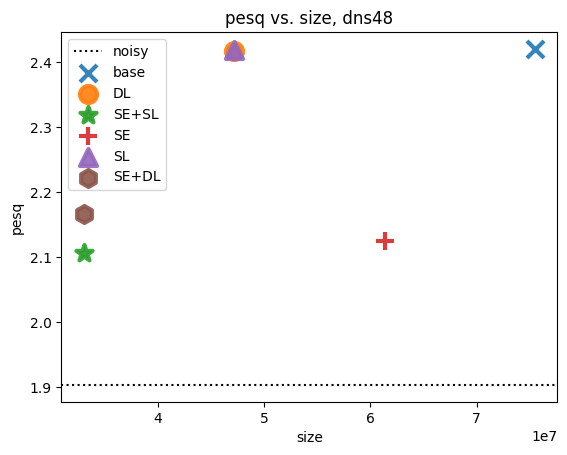

In [33]:
markers = ['x', 'o', '*', '+', '^', 'h']
names = ['base', 'DL', 'SE+SL', 'SE', 'SL', 'SE+DL']
df.model = ['noisy'] + names
marker_dict = dict(zip(names, markers))
plt.axhline(y=1.9032, linestyle=':', color='k', label='noisy')
for i, row in df.iterrows():
  if row['model'] != 'noisy':
    x,y = row['size'], row['pesq']
    plt.scatter(x, y, s=150, marker=marker_dict[row['model']], alpha=0.9, label=row['model'], linewidth=3)
plt.legend()
plt.xlabel('size')
plt.ylabel('pesq')
plt.title('pesq vs. size, dns48')
plt.show()

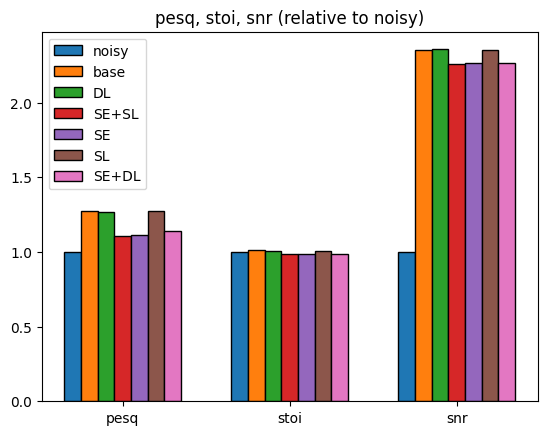

In [9]:
metrics = ['pesq', 'stoi', 'snr']
x = np.arange(len(metrics))
for i in range(len(df)):
  plt.bar(x + 0.1 * i, df.iloc[i][['pesq', 'stoi', 'snr']] / df[df.model == 'noisy'].iloc[0][['pesq', 'stoi', 'snr']], width=0.1, edgecolor='black', label=df.iloc[i]['model'])
plt.legend()
plt.xticks(x+0.3, metrics)
plt.title('pesq, stoi, snr (relative to noisy)')
plt.show()